# Malaria Diagnosis With CNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer,Conv2D, MaxPool2D, Dense, Flatten,BatchNormalization,RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, CSVLogger,LearningRateScheduler,ModelCheckpoint

In [2]:
from tensorflow.keras.metrics import BinaryAccuracy,FalsePositives,FalseNegatives,TruePositives,TrueNegatives,Precision,Recall,AUC

# Loading The Dataset

In [23]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True,shuffle_files=True,split=['train'])


In [4]:
for data in dataset[0].take(1):
  print(data)
  break

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [24]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

# Data Visualization

In [25]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

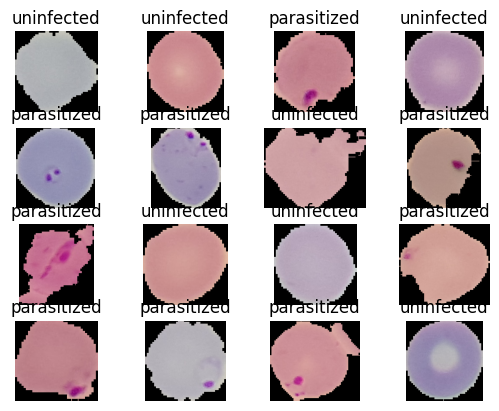

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
augmented_image = tf.image.flip_left_right(original_image)

In [ ]:
augmented_img = tf.image.random_flip_up_down(original_image)

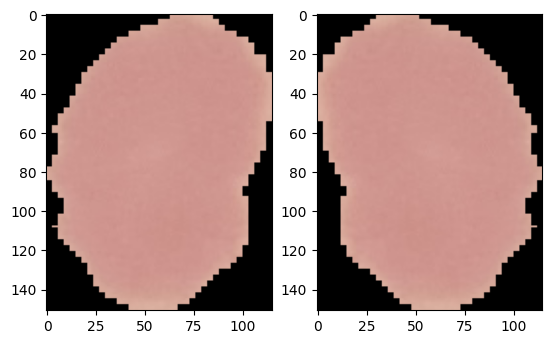

In [ ]:
visualize(original_image, augmented_image)

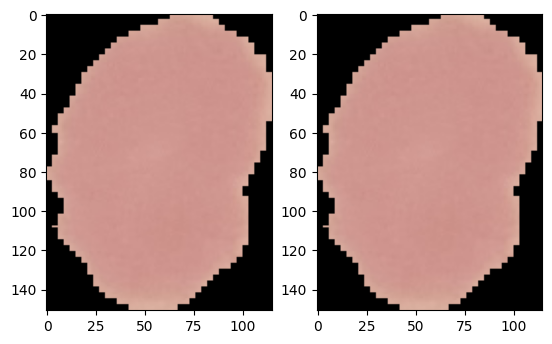

In [ ]:
visualize(original_image,augmented_img)

In [ ]:
augmented_img1 = tf.image.rot90(original_image)

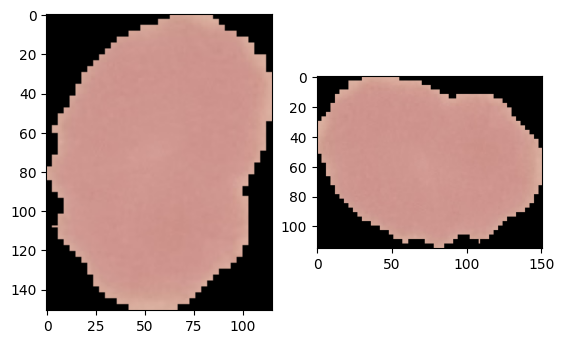

In [ ]:
visualize(original_image,augmented_img1)

# Data Preprocessing

In [26]:
IM_SIZE=224
def resize_rescale(image, label):

  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255, label

In [27]:
### tf.keras.layers resizing and rescaling
resize_rescale_layers = Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])

**Creating a function augment for data augmentation**

In [28]:
# tf.image augmentation
def augment(image, label):
  image, label = resize_rescale(image,label)
  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor=0.3)
  image = tf.image.flip_left_right(image)

  return image,label

In [10]:

# tf.keras.layer augmentation
augment_layers = Sequential([
    RandomRotation(factor=(0.25,0.2501),),
    RandomFlip(mode='horizontal',),
])

def augment_layer(image,label):

  return augment_layers(resize_rescale_layers(image),training=True), label

In [ ]:
"""
train_dataset=train_dataset.map(augment)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)

"""

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [29]:
train_dataset = (
 train_dataset
.shuffle(buffer_size=8,reshuffle_each_iteration=True)
#.map(augment)
.batch(1)
.prefetch(tf.data.AUTOTUNE)
)

In [30]:
val_dataset = (
     val_dataset
     .shuffle(buffer_size=8,reshuffle_each_iteration=True)
    # .map(resize_rescale)
     .batch(1)
               .prefetch(tf.data.AUTOTUNE)
)

In [13]:
test_dataset = test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


# Model Creation

In [14]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    resize_rescale_layers,  # From the above seqeuntial layer created
    augment_layers,

    Conv2D(filters=6,kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),


    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),

    Flatten(),

    Dense(128, activation="relu"),
    BatchNormalization(),

    Dense( 10, activation="relu"),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

In [ ]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0227046>

In [16]:
metrics = [BinaryAccuracy(name='accuracy'),FalsePositives(name='fp'),FalseNegatives(name='fn'),TruePositives(name='tp'),TrueNegatives(name='tn'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [31]:

lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics=metrics)

In [32]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)#,callbacks=[csv_callback])

Epoch 1/5
22046/22046 [==============================] - 239s 10ms/step - loss: 0.6946 - accuracy: 0.4972 - fp: 5452.0000 - fn: 5633.0000 - tp: 5391.0000 - tn: 5570.0000 - precision: 0.4972 - recall: 0.4890 - auc: 0.4967 - val_loss: 14.2078 - val_accuracy: 0.5230 - val_fp: 856.0000 - val_fn: 458.0000 - val_tp: 930.0000 - val_tn: 511.0000 - val_precision: 0.5207 - val_recall: 0.6700 - val_auc: 0.5275
Epoch 2/5
22046/22046 [==============================] - 221s 10ms/step - loss: 0.6945 - accuracy: 0.5002 - fp: 5461.0000 - fn: 5558.0000 - tp: 5468.0000 - tn: 5559.0000 - precision: 0.5003 - recall: 0.4959 - auc: 0.4988 - val_loss: 14.1855 - val_accuracy: 0.5241 - val_fp: 856.0000 - val_fn: 455.0000 - val_tp: 937.0000 - val_tn: 507.0000 - val_precision: 0.5226 - val_recall: 0.6731 - val_auc: 0.5255
Epoch 3/5
22046/22046 [==============================] - 221s 10ms/step - loss: 0.6946 - accuracy: 0.4962 - fp: 5499.0000 - fn: 5608.0000 - tp: 5417.0000 - tn: 5522.0000 - precision: 0.4962 - re

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self,epoch,logs):
    print("\nFor Epoch Number {} the model has a loss {}".format(epoch,logs['loss']))
  def on_batch_end(self, batch,logs):
    print("\n For Batch Number {} the model has a loss of {}".format(batch+1,logs))

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

**Model Training**

**The Callback will Store the training history in the CSV File Named as logs.csv (from the above cell)**

In [ ]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1,callbacks=[csv_callback])

Epoch 1/5
689/689 [==============================] - 61s 88ms/step - loss: 0.2359 - accuracy: 0.9201 - fp: 1221.0000 - fn: 540.0000 - tp: 10484.0000 - tn: 9801.0000 - precision: 0.8957 - recall: 0.9510 - auc: 0.9595 - val_loss: 0.3315 - val_accuracy: 0.9074 - val_fp: 123.0000 - val_fn: 132.0000 - val_tp: 1259.0000 - val_tn: 1241.0000 - val_precision: 0.9110 - val_recall: 0.9051 - val_auc: 0.9479
Epoch 2/5
689/689 [==============================] - 52s 76ms/step - loss: 0.2291 - accuracy: 0.9207 - fp: 1105.0000 - fn: 644.0000 - tp: 10381.0000 - tn: 9916.0000 - precision: 0.9038 - recall: 0.9416 - auc: 0.9636 - val_loss: 0.3607 - val_accuracy: 0.8947 - val_fp: 178.0000 - val_fn: 112.0000 - val_tp: 1275.0000 - val_tn: 1190.0000 - val_precision: 0.8775 - val_recall: 0.9193 - val_auc: 0.9570
Epoch 3/5
689/689 [==============================] - 51s 74ms/step - loss: 0.2423 - accuracy: 0.9123 - fp: 1163.0000 - fn: 770.0000 - tp: 10254.0000 - tn: 9859.0000 - precision: 0.8981 - recall: 0.9302 

# Model Visualization

<Axes: >

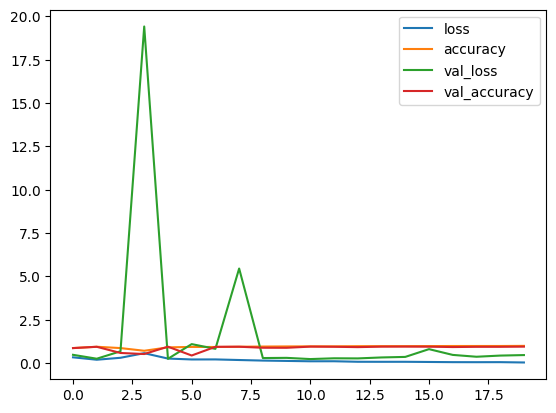

In [ ]:
import pandas as pd
losses = pd.DataFrame(history.history)
losses.plot()

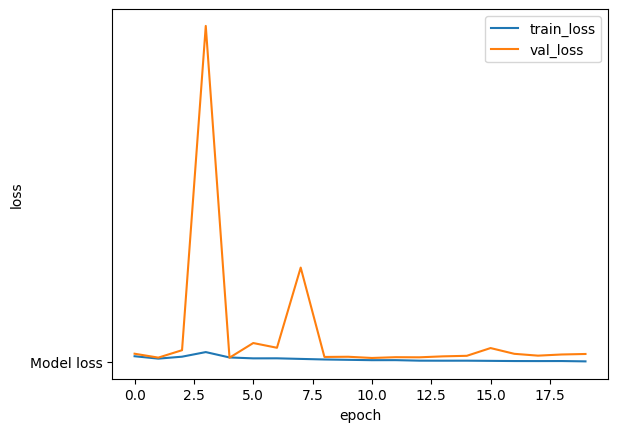

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

# Saving and Loading Model

In [ ]:
from tensorflow.keras.models import load_model
lenet_model.save('malaria')

In [ ]:
loaded_model = load_model('malaria')
loaded_model.evaluate(test_dataset)

87/87 [==============================] - 13s 45ms/step - loss: 0.5007 - accuracy: 0.9369


[0.5007435083389282, 0.9368879199028015]

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Evaluation

In [ ]:
#lenet_model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if (x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 26ms/step


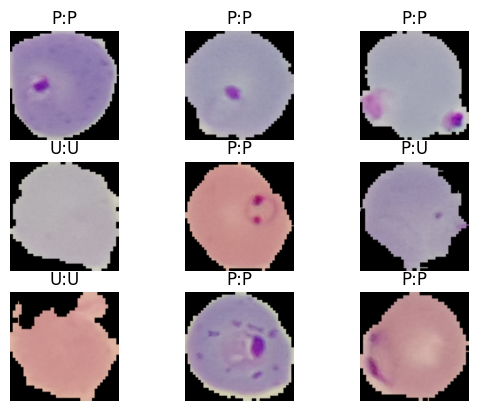

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":"+ str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
!!cp -r "/content/malaria" "/content/drive/My Drive/"


[]

# EarlyStopping

In [ ]:
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
metrics = [BinaryAccuracy(name='accuracy'),FalsePositives(name='fp'),FalseNegatives(name='fn'),TruePositives(name='tp'),TrueNegatives(name='tn'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics=metrics)

In [ ]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1,callbacks=[es_callback])

Epoch 1/10
689/689 [==============================] - 46s 67ms/step - loss: 0.1684 - accuracy: 0.9416 - fp: 972.0000 - fn: 316.0000 - tp: 10710.0000 - tn: 10048.0000 - precision: 0.9168 - recall: 0.9713 - auc: 0.9790 - val_loss: 0.2134 - val_accuracy: 0.9423 - val_fp: 118.0000 - val_fn: 41.0000 - val_tp: 1350.0000 - val_tn: 1246.0000 - val_precision: 0.9196 - val_recall: 0.9705 - val_auc: 0.9800
Epoch 2/10
689/689 [==============================] - 44s 64ms/step - loss: 0.1793 - accuracy: 0.9360 - fp: 1118.0000 - fn: 294.0000 - tp: 10729.0000 - tn: 9905.0000 - precision: 0.9056 - recall: 0.9733 - auc: 0.9749 - val_loss: 0.2399 - val_accuracy: 0.9089 - val_fp: 234.0000 - val_fn: 17.0000 - val_tp: 1377.0000 - val_tn: 1127.0000 - val_precision: 0.8547 - val_recall: 0.9878 - val_auc: 0.9657


In [ ]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 16s 40ms/step - loss: 0.5412 - accuracy: 0.5125 - fp: 6.0000 - fn: 1338.0000 - tp: 27.0000 - tn: 1386.0000 - precision: 0.8182 - recall: 0.0198 - auc: 0.9648


[0.5412297248840332,
 0.5125135779380798,
 6.0,
 1338.0,
 27.0,
 1386.0,
 0.8181818127632141,
 0.019780220463871956,
 0.9647789597511292]

# Learning Rate Scheduler

In [ ]:
def scheduler(epoch, lr):
  if epoch <=3:
    return lr
  else:
    return lr*tf.math.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics=metrics)

In [ ]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1,callbacks=[scheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
689/689 [==============================] - 51s 69ms/step - loss: 0.1579 - accuracy: 0.9420 - fp: 1149.0000 - fn: 289.0000 - tp: 12127.0000 - tn: 11236.0000 - precision: 0.9135 - recall: 0.9767 - auc: 0.9793 - val_loss: 0.3954 - val_accuracy: 0.8838 - val_fp: 307.0000 - val_fn: 13.0000 - val_tp: 1375.0000 - val_tn: 1060.0000 - val_precision: 0.8175 - val_recall: 0.9906 - val_auc: 0.9581 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10
689/689 [==============================] - 51s 73ms/step - loss: 0.1437 - accuracy: 0.9507 - fp: 807.0000 - fn: 279.0000 - tp: 10746.0000 - tn: 10214.0000 - precision: 0.9301 - recall: 0.9747 - auc: 0.9836 - val_loss: 0.1969 - val_accuracy: 0.9332 - val_fp: 158.0000 - val_fn: 26.0000 - val_tp: 1364.0000 - val_tn: 1207.0000 - val_precision: 0.8962 - val_recall: 0.9813 - val_auc: 0.9779 - lr: 0.0100

Epoch 3: Learnin

# Model Checkpoints

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch'
)

**The model training checkpoints are saved in assets folder**

In [ ]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1,callbacks=[checkpoint_callback])

Epoch 1/10
689/689 [==============================] - 67s 74ms/step - loss: 0.2824 - accuracy: 0.8934 - fp: 1467.0000 - fn: 884.0000 - tp: 10139.0000 - tn: 9556.0000 - precision: 0.8736 - recall: 0.9198 - auc: 0.9490 - val_loss: 0.2429 - val_accuracy: 0.9419 - val_fp: 101.0000 - val_fn: 59.0000 - val_tp: 1332.0000 - val_tn: 1263.0000 - val_precision: 0.9295 - val_recall: 0.9576 - val_auc: 0.9755
Epoch 2/10
689/689 [==============================] - 52s 76ms/step - loss: 0.2566 - accuracy: 0.9049 - fp: 1254.0000 - fn: 843.0000 - tp: 10178.0000 - tn: 9771.0000 - precision: 0.8903 - recall: 0.9235 - auc: 0.9582 - val_loss: 0.3507 - val_accuracy: 0.8853 - val_fp: 292.0000 - val_fn: 24.0000 - val_tp: 1368.0000 - val_tn: 1071.0000 - val_precision: 0.8241 - val_recall: 0.9828 - val_auc: 0.9658
Epoch 3/10
689/689 [==============================] - 53s 77ms/step - loss: 0.1956 - accuracy: 0.9316 - fp: 975.0000 - fn: 532.0000 - tp: 10491.0000 - tn: 10048.0000 - precision: 0.9150 - recall: 0.9517